In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt

In [2]:
transf=tv.transforms.Compose([tv.transforms.ToTensor(), #De esta forma podemos transformar los tragers a media0
                             tv.transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
                                                    #value-mean      #std-dev

In [3]:
B=100    #batch size
trn_data = tv.datasets.CIFAR10( # Entrenamiento.
            root='./data', train=True, download=True,
            transform=tv.transforms.ToTensor() )
tst_data = tv.datasets.CIFAR10( # Validacion.
            root='./data', train=False, download=True,
            transform=tv.transforms.ToTensor() )
trn_load = torch.utils.data.DataLoader(
            dataset=trn_data, batch_size=B, shuffle=True)
tst_load = torch.utils.data.DataLoader(
            dataset=tst_data, batch_size=B, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
#convolucional
k=3
s=1
p=1

#MaxPol
k=2
s=2

In [5]:
#La idea es ahora trabajar con un loto (Bathc) hacemos las cuentas y vemos que dimensiones tiene el resultado

In [6]:
idata=iter(tst_load)   #me crea un itreador
image, label=next(idata)  #Con esto obtengo el proximo elemento del dataset
image.shape               #Me da la dimension del

torch.Size([100, 3, 32, 32])

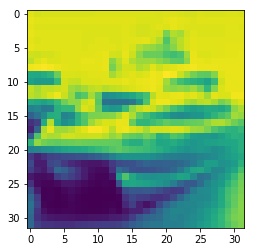

In [7]:
plt.imshow(image[1,2,:,:])     #Graficamos la imagen
plt.show()

#  Capa convolucional

In [8]:
kernel_size=5
stride=2
padding=2
in_ch=3
out_ch=16

convolucion1 = torch.nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)  #reacliza una covolucion: parametros entrenables
out=convolucion1(image)
out.shape

torch.Size([100, 16, 16, 16])

In [9]:
kernel_size=3
stride=1
padding=1
in_ch=16
out_ch=32

convolucion2 = torch.nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding)#reacliza una covolucion: parametros entrenables
out2=convolucion2(out)
out2.shape

torch.Size([100, 32, 16, 16])

In [10]:
#MaxPol
kernel_maxpool=2
stride_maxpool=2


mp = torch.nn.MaxPool2d(kernel_maxpool,stride_maxpool)               #Hace maxpooling: se queda con el mayor de la grilla

out3=mp(out2)
out3.shape

torch.Size([100, 32, 8, 8])

# Ahora creamos la clase

Ya tenemos las medidas de nuestro modelo. Van a estar harcodeadas dentro de la clase
Para idependizarnos del batch-size usamos view(-1,32 * 8 * 8).

<h1>ReLu</h1>
<p>La relu nos da un tipo de activación dispersa. Crea una buena aproximacion de la entrada usando pocas unidades. Cuando hacemos modelos mas complejos es necesario utilizar GPU's. La ReLu se puede computar mas rápido que la tanh y que la sigmoide.</p>
<p>La ReLu la aplicamos despues de aplicar maxpooling, ya que si lo hacemos antes podemos llegar a perder los valores negativos cosa que no pasa con maxpooling.</p>
<p>La ReLu tira la parte negativa, entonces necesitaria 2 canales para poder obtener la misma información que puedo tener con otro tipo de función de activación</p>

In [11]:
class CN(torch.nn.Module):
    def __init__(N):       #Metodo constructor de SAE
        super().__init__()
        _.c1 = torch.nn.Conv2d(3,16,5,2,2)
        _.c2 = torch.nn.Conv2d(16,32,3,1,1)
        _.mp = torch.nn.MaxPool2d(2,2)
        _.L1=torch.nn.Linear(32*23*8,512)
        _.L2=torch.nn.Linear(512,N)
        
        
    def forward(_,x):
        out1 = _.c1(x)                                    #primer convolución
        out2 = _.c2(out1)                                 #segunda convolucion, seguida de maxpooling y ReLu
        out3 = torch.nn.Tanh(_.mp(out2).view(-1,32*8*8))  #con view forzamos a que tenga estas dimensiones. con -1 se aplica a todo el batch
        out4 = torch.nn.Tanh(_.L1(out3))   #aca utilizamos otra función de activación
        out5 = _.L2(out4)            #La salida es lineal
        return out5

In [12]:
E,t=1.0,0                              #Condiciones iniciales

E_list = list()                      #Creo listas para graficar el error
t_list =list()

E_list.append(E)
t_list.append(t)

In [13]:
modelo=CN(10)               #definimos el modelo
optim=torch.optim.SGD(modelo.parameters(),lr=0.1)   #Seteo como hacer la optimización
costf=torch.nn.CrossEntropyLoss()
modelo.train()     #esto hace que los calculos sean hechos como si estuviera entrenando


T=3
for t in range(T):
    for images, labels in trn_load:
            optim.zero_grad()
            data=images
            y = modelo(data)
            loss = costf( y, labels)
            loss.backward()
            optim.step()
            E += loss.item()
    E_list.append(E)    
    t_list.append(t)
    t+=1
    if t%100==0:
        print(t,E)
    print("Clasificador lineal: ",t, E)



TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
plt.plot(t_list,E_list)
plt.show()

# Autoencoders

Si a la entrada de un autoencoder convolucional pongo immagenes con ruido y a la salida la imagen original, aprende a filtrar imagenes. Podemos hacer que coloree imagenes. Es decir podemos crear una red que revierte filtros